In [1]:
from datasets import load_dataset, Dataset
import sys, os, json, re
sys.path.append(os.path.join(os.getcwd(), '../..'))
from OPRO import OPRO
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from tqdm.auto import tqdm, trange
from rouge import Rouge

def rouge_scorer():
    # Initialize the Rouge object
    rouge = Rouge()

    def compute_scores(generated_text, reference_text):
        # Compute the scores
        scores = rouge.get_scores(generated_text, reference_text)[0]
        total_score = 0
        for r in scores:
            total_score += scores[r]['f']
        return total_score/3

    return compute_scores

# Usage
score_rouge = rouge_scorer()
opro = OPRO(["gemini", "gemma", "llama2", "anthropic"])
# dataset = load_dataset("pisterlabs/promptset").filter(lambda row: len(row["prompts"]) > 0)["train"]
# CHOSEN_PROMPT = dataset["prompts"][404][0].replace("PLACEHOLDER", "{LANGUAGE}", 1).replace("PLACEHOLDER", "{TEXT}", 1)
CHOSEN_PROMPT = 'Please summarize the following text: PLACEHOLDER'  # somewhere in promptset. Will find idx later
CHOSEN_PROMPT = CHOSEN_PROMPT.replace("PLACEHOLDER", "{TEXT}")
CHOSEN_PROMPT

'Please summarize the following text: {TEXT}'

### Original Dataset

In [2]:
summary_dataset = load_dataset("billsum", split="ca_test")
summary_dataset

Dataset({
    features: ['text', 'summary', 'title'],
    num_rows: 1237
})

### Generate Synthetic Data

In [3]:
# Generate a question and answer pair using a language model
def generate_qa_pair():
    prompt_template = """You are a helpful assistant designed to generate synthetic text-summary pairs for the prompt: {CHOSEN_PROMPT}.

Please generate a text and the text summary that is similar to the following text and text summary pair as a JSON object:

{{
    "text": \"\"\"{text}\"\"\",
    "summary": \"\"\"{summary}\"\"\"
}}

Make sure the questions and answers are string values.
Take a deep breath and think step-by-step. Respond with only the JSON object!
"""

    response = opro.generate(
        prompt_template.format(
            CHOSEN_PROMPT=CHOSEN_PROMPT,
            text=summary_dataset["text"][0],
            summary=summary_dataset["summary"][0],
        ),
        model="gemini",  # gemini
        is_indeterministic=True,
    )

    return eval(response)

SYNTHETIC_DATA_FILEPATH = "synthetic_summarization_dataset.json"
if not os.path.exists(SYNTHETIC_DATA_FILEPATH):
    qa_pairs = []
    SAMPLE_SIZE = 40

    # Generating synthetic data
    pbar = tqdm(total=SAMPLE_SIZE)
    while len(qa_pairs) < SAMPLE_SIZE:
        try:
            qa_pair = generate_qa_pair()
            qa_pairs.append(qa_pair)
            pbar.update(1)
        except Exception as e:
            print(e)
    pbar.close()

    # Saving to file
    with open(SYNTHETIC_DATA_FILEPATH, "w") as f:
        f.write(str(qa_pairs))

# Reading saved data
with open(SYNTHETIC_DATA_FILEPATH, "r") as f:
    qa_pairs = eval(f.read())

qa_pairs

[{'text': "It is important to protect your personal data when using the internet. This includes being careful about what information you share online, using strong passwords, and being aware of the privacy settings on your social media accounts. \n\nYou should also be careful about clicking on links in emails or text messages from people you don't know. These links could lead to phishing websites that are designed to steal your personal information. If you're not sure whether a link is safe, it's best to err on the side of caution and not click on it.\n\nIt's also important to be aware of the privacy policies of the websites and apps you use. These policies will tell you how your personal data will be used. If you're not comfortable with the way a website or app is using your data, you can choose not to use it.\n\nProtecting your personal data is important for your safety and security. By taking a few simple steps, you can help to protect yourself from identity theft and other online t

In [4]:
TRAINING_SAMPLE_SIZE = 10
TESTING_SAMPLE_SIZE = 25

training_sample = Dataset.from_dict(
    {
        "text": [pair["text"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
        "summary": [pair["summary"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
    }
)

testing_sample = Dataset.from_dict(
    {
        "text": [
            pair["text"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
        "summary": [
            pair["summary"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
    }
)

# Checking if the lists are parallel, i.e. the question and answer at the same index are related
len(training_sample["text"]), len(training_sample["summary"]), len(testing_sample["text"]), len(testing_sample["summary"])

(10, 10, 25, 25)

### Optimize Prompt on Synthetic Data

In [5]:
def has_correct_keywords(s):
    extract_keys = lambda x: re.findall(r'{(.*?)}', x)
    return extract_keys(s) == ['TEXT']


def opt_llm(instruction_score_pairs):
    # Format the instruction and score pairs into a string
    pairs_str = ""
    for ins, score in instruction_score_pairs.items():
        pairs_str += f"text:\n{ins}\nscore:\n{score:.2f}\n\n"

    prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

Here are some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

{pairs_str}

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
New instruction:
"""
    response = ""
    while not has_correct_keywords(response):
        response = opro.generate(
            prompt.format(pairs_str=pairs_str),
            model="gemini",  # gemini
            is_indeterministic=True,
        )
    return response


def score(prompt, sample):
    """
    Score the instruction using the sample.

    Args:
    instruction: str
    sample: Dataset with "question" and "answer" as keys

    Returns:
    accuracy: float
    """
    accuracy = 0
    with tqdm(sample, desc=prompt, position=1, leave=False) as pbar:
        for idx, sample_qa in enumerate(pbar):
            res = opro.generate(
                prompt.format(TEXT=sample_qa["text"]),
                model="gemma",  # gemma
            )
            # Heuristic for detecting correctness
            accuracy += score_rouge(res, sample_qa["summary"])
            pbar.set_postfix({"Accuracy": f"{accuracy / (idx + 1):.2f}"})

    return accuracy / len(sample) * 100

In [6]:
INS_PER_STEP = 8
MAX_INS_SCORE_PAIRS = 20
SAVE_PATH = "synthetic_summarization_OPRO_results.json"

# loading saved data
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        results = json.load(f)
    starting_step = len(results) + 1
    ins_score_pairs = results[str(len(results))]
else:
    ins_lst = [
        CHOSEN_PROMPT,
        f"{CHOSEN_PROMPT}. Think step by step.",
        f"{CHOSEN_PROMPT}. Take a deep breath.",
        f"{CHOSEN_PROMPT}. Be concise and clear.",
        f"{CHOSEN_PROMPT}. You are a summarization expert.",
        f"{CHOSEN_PROMPT}. Explain your answer in simple terms.",
        f"{CHOSEN_PROMPT}. You are a helpful assistant.",
        # Prompt1 from Suggest Prompt
        """#### Instruction ####

Summarize the following text:

#### Input ####

{TEXT}

#### Expected Response Format ####

[Your summary]""",
        # Prompt2 from Suggest Prompt
        """**Instruction**: Summarize the following text:

**{TEXT}**

**Example:**

* Summarize the following text:
> The United States is a large country with a diverse population. It is made up of 50 states, each with its own unique culture and history. The United States is a global superpower and has a significant influence on world affairs.

### Answer: ###
* The United States is a large, diverse country with 50 states, each with its own unique culture and history. As a global superpower, the United States exerts significant influence on world affairs.

**Additional Instructions:**

* Please ensure that your summary captures the key points of the text.
* Use clear and concise language.
* You MUST adhere to the specified word limit.
* You will be penalized if your summary is not responsive to the text.""",
        # Prompt3 from Suggest Prompt
        """###Instruction###

Summarize the following text:

###Input###
{TEXT}

###Your task is###

Generate a concise and accurate summary of the input text.

###You MUST###

* Write in clear and concise language.
* Cover all the main points of the text.
* Keep the summary within 500 words.

###You will be penalized if###

* Your summary is incomplete or inaccurate.
* Your summary exceeds the 500-word limit.

###Answer in a natural, human-like manner###

Pretend you are a highly skilled human summarizing the text.

###Example###
* **QUESTION:** Summarize the following text:
{{EXAMPLE TEXT}}
* **SUMMARY:** {{EXAMPLE SUMMARY}}

###TIP###
I'm going to tip $5 for a better summary!""",
        # Prompt4 from Suggest Prompt
        """###Instruction###
Your task is to summarize the following text:


###Example###
{TEXT}


You MUST answer in a natural, human-like manner. You will be penalized for not following these instructions.
###Question###
{TEXT}""",
        # Prompt5 from Suggest Prompt
        """###Instruction###
Provide a concise summary of the following text:
{TEXT}
###Example###
Input: Here is the provided request: \"Summarize this research paper: Effects of Climate Change on Marine Ecosystems\"
Output: Marine ecosystems face significant threats from climate change, including rising sea temperatures, ocean acidification, and altered weather patterns. These changes disrupt ecological balances, leading to loss of biodiversity, shifts in species distribution, and reduced productivity.
###Question###
Your task is to generate a concise and informative summary of the provided text. Ensure your response is clear, concise, and free from errors. You MUST adhere to the formatting guidelines and provide a single cohesive summary. If you fail to meet these requirements, you will be penalized.
Answer in a natural, human-like manner and ensure your response is comprehensive and covers the main points of the provided text.""",
    ]
    ins_score_pairs = {
        ins: score(ins, training_sample)
        for ins in tqdm(ins_lst, desc="Scoring", position=0)
    }
    starting_step = 1
    results = {starting_step: ins_score_pairs}
    with open(SAVE_PATH, "w") as f:
        json.dump(results, f)

# Each step takes aboy 5 to 10 minutes with gemma:2b
STEP_COUNT = 10
TARGET_STEP = starting_step + STEP_COUNT
assert TARGET_STEP >= starting_step, "TARGET_STEP should be greater than step."
for i in range(starting_step, TARGET_STEP):
    print(f"Step {i}")
    while True:
        try:
            # Optimizer LLM
            instructions = [
                opt_llm(ins_score_pairs)
                for _ in trange(INS_PER_STEP, desc="Optimizing")
            ]
            print(instructions)

            # Scoring the new instructions
            new_ins_score_pairs = {
                ins: score(ins, training_sample)
                for ins in tqdm(instructions, desc="Scoring", position=0)
            }
            print(new_ins_score_pairs)
            combined_ins_score_pairs = {**ins_score_pairs, **new_ins_score_pairs}
            ins_score_pairs = dict(
                sorted(
                    combined_ins_score_pairs.items(), key=lambda x: x[1], reverse=True
                )[:MAX_INS_SCORE_PAIRS]
            )

            # Saving data
            results[i] = ins_score_pairs
            with open(SAVE_PATH, "w") as f:
                json.dump(results, f)

            break
        except ValueError as e:
            print(e)
        except Exception as e:
            print(e)

Scoring:   0%|          | 0/12 [00:00<?, ?it/s]

Please summarize the following text: {TEXT}:   0%|          | 0/10 [00:00<?, ?it/s]

Please summarize the following text: {TEXT}. Think step by step.:   0%|          | 0/10 [00:00<?, ?it/s]

Please summarize the following text: {TEXT}. Take a deep breath.:   0%|          | 0/10 [00:00<?, ?it/s]

Please summarize the following text: {TEXT}. Be concise and clear.:   0%|          | 0/10 [00:00<?, ?it/s]

Please summarize the following text: {TEXT}. You are a summarization expert.:   0%|          | 0/10 [00:00<?, …

Please summarize the following text: {TEXT}. Explain your answer in simple terms.:   0%|          | 0/10 [00:0…

Please summarize the following text: {TEXT}. You are a helpful assistant.:   0%|          | 0/10 [00:00<?, ?it…

#### Instruction ####

Summarize the following text:

#### Input ####

{TEXT}

#### Expected Response Format #…

**Instruction**: Summarize the following text:

**{TEXT}**

**Example:**

* Summarize the following text:
> Th…

###Instruction###

Summarize the following text:

###Input###
{TEXT}

###Your task is###

Generate a concise a…

###Instruction###
Your task is to summarize the following text:


###Example###
{TEXT}


You MUST answer in a …

###Instruction###
Provide a concise summary of the following text:
{TEXT}
###Example###
Input: Here is the pro…

Step 1


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['### Instruction ###\nSummarize the following text:\n\n### Text ###\n{TEXT}\n\n### Answer in the format of ###\n[Your summary]', 'Summarize the following text: {TEXT}. Be comprehensive, concise, and accurate.', 'Summarize the following text: {TEXT}.', 'Summarize the following text: {TEXT} Make sure the answer is natural and comprehensive.', 'You are a critical thinker. Please summarize the following text:\n{TEXT}.\nEnsure that your summary is well-written and concise.', 'Summarize the following text:\n{TEXT}\nExplain your answer in simple terms.', 'Please summarize the following text: {TEXT}. I need this to be in 400 words and under.', '**Instruction**: Summarize the following text:\n\n**{TEXT}**\n\n**Example:**\n\n* Summarize the following text:\n> The United States is a large country with a diverse population. It is made up of 50 states, each with its own unique culture and history. The United States is a global superpower and has a significant influence on world affairs.\n\n### Ans

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

### Instruction ###
Summarize the following text:

### Text ###
{TEXT}

### Answer in the format of ###
[Your …

Summarize the following text: {TEXT}. Be comprehensive, concise, and accurate.:   0%|          | 0/10 [00:00<?…

Summarize the following text: {TEXT}.:   0%|          | 0/10 [00:00<?, ?it/s]

Summarize the following text: {TEXT} Make sure the answer is natural and comprehensive.:   0%|          | 0/10…

You are a critical thinker. Please summarize the following text:
{TEXT}.
Ensure that your summary is well-writ…

Summarize the following text:
{TEXT}
Explain your answer in simple terms.:   0%|          | 0/10 [00:00<?, ?it…

Please summarize the following text: {TEXT}. I need this to be in 400 words and under.:   0%|          | 0/10 …

**Instruction**: Summarize the following text:

**{TEXT}**

**Example:**

* Summarize the following text:
> Th…

{'### Instruction ###\nSummarize the following text:\n\n### Text ###\n{TEXT}\n\n### Answer in the format of ###\n[Your summary]': 34.17651455682913, 'Summarize the following text: {TEXT}. Be comprehensive, concise, and accurate.': 47.63399093031041, 'Summarize the following text: {TEXT}.': 42.266794684537174, 'Summarize the following text: {TEXT} Make sure the answer is natural and comprehensive.': 48.482160952774194, 'You are a critical thinker. Please summarize the following text:\n{TEXT}.\nEnsure that your summary is well-written and concise.': 42.35481365670522, 'Summarize the following text:\n{TEXT}\nExplain your answer in simple terms.': 43.19542781042735, 'Please summarize the following text: {TEXT}. I need this to be in 400 words and under.': 46.54217054510298, '**Instruction**: Summarize the following text:\n\n**{TEXT}**\n\n**Example:**\n\n* Summarize the following text:\n> The United States is a large country with a diverse population. It is made up of 50 states, each with it

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Generate unique texts that have the highest possible score. Make sure the text is different from the ones provided in the examples.\nNew text:\nSummarize the following text:\n{TEXT}.\nMake sure to capture the key points and present them concisely.\nAvoid using technical or overly formal language.\nYou may assume that the reader has some knowledge of the topic and knows the background information related to the text.\n\nRemember, your summary should accurately present the main points of the text while being clear, comprehensive, and engaging.', 'Summarize the following text:\n{TEXT}\nPlease be detailed and precise.\nExample Response:\nSummarize the provided text while maintaining its meaning and structure.\n\nAnswer in a clear, concise, and correct manner.', 'Summarize the following text:\n{TEXT}\nRemember that your answer should sound natural and comprehensive.', '###Instruction###\nProvide a concise summary of the following text:\n{TEXT}\n###Example###\n**Input**: Summarize the foll

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Generate unique texts that have the highest possible score. Make sure the text is different from the ones prov…

Summarize the following text:
{TEXT}
Please be detailed and precise.
Example Response:
Summarize the provided …

Summarize the following text:
{TEXT}
Remember that your answer should sound natural and comprehensive.:   0%| …

###Instruction###
Provide a concise summary of the following text:
{TEXT}
###Example###
**Input**: Summarize t…

###Instruction###

Summarize the following text:

###{TEXT}

###Format###
[Your summary]
score::   0%|        …

**Instruction:**

Compose a comprehensive summary of the provided article. Analyze the key points effectively.…

Summarize the following text, keep it comprehensive, concise, and accurate, along with being natural and human…

**Instruction:**

**Summarize the text below:**

{TEXT}<!-- The temperature has been rising globally, leading …

{'Generate unique texts that have the highest possible score. Make sure the text is different from the ones provided in the examples.\nNew text:\nSummarize the following text:\n{TEXT}.\nMake sure to capture the key points and present them concisely.\nAvoid using technical or overly formal language.\nYou may assume that the reader has some knowledge of the topic and knows the background information related to the text.\n\nRemember, your summary should accurately present the main points of the text while being clear, comprehensive, and engaging.': 37.77221259681477, 'Summarize the following text:\n{TEXT}\nPlease be detailed and precise.\nExample Response:\nSummarize the provided text while maintaining its meaning and structure.\n\nAnswer in a clear, concise, and correct manner.': 41.89624647952724, 'Summarize the following text:\n{TEXT}\nRemember that your answer should sound natural and comprehensive.': 45.73327250059963, '###Instruction###\nProvide a concise summary of the following te

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Summarize the following text:\n{TEXT}\nProvide a concise yet comprehensive summary, ensuring accuracy and a natural, human-like tone in your response.', 'Summarize the following text: {TEXT}.  Your summary should showcase both your language proficiency and summarization skills. Prove to me that you can craft a great summary that is both natural and informative.', 'Summarize the following text:\n\n{TEXT}\n\nResponse Format should be [Your summary]', 'Summarize the following text:\n{TEXT}\nRemember to be accurate and clear.', 'Summarize the following text in a concise and information-rich manner:\n{TEXT}', 'Summarize the following text:\n{TEXT}.\nThere is no specific length requirement. Just make the summary as concise as possible, but cover the essence of the text.', 'Please summarize the following text: {TEXT}. Make sure the answer is concise, clear and accurate.', 'Summarize the following text in a way that is both concise and comprehensive, covering all the main points with natural

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Summarize the following text:
{TEXT}
Provide a concise yet comprehensive summary, ensuring accuracy and a natu…

Summarize the following text: {TEXT}.  Your summary should showcase both your language proficiency and summari…

Summarize the following text:

{TEXT}

Response Format should be [Your summary]:   0%|          | 0/10 [00:00<…

Summarize the following text:
{TEXT}
Remember to be accurate and clear.:   0%|          | 0/10 [00:00<?, ?it/s…

Summarize the following text in a concise and information-rich manner:
{TEXT}:   0%|          | 0/10 [00:00<?,…

Summarize the following text:
{TEXT}.
There is no specific length requirement. Just make the summary as concis…

Please summarize the following text: {TEXT}. Make sure the answer is concise, clear and accurate.:   0%|      …

Summarize the following text in a way that is both concise and comprehensive, covering all the main points wit…

{'Summarize the following text:\n{TEXT}\nProvide a concise yet comprehensive summary, ensuring accuracy and a natural, human-like tone in your response.': 37.09975474708219, 'Summarize the following text: {TEXT}.  Your summary should showcase both your language proficiency and summarization skills. Prove to me that you can craft a great summary that is both natural and informative.': 42.60102566815697, 'Summarize the following text:\n\n{TEXT}\n\nResponse Format should be [Your summary]': 44.22059013329303, 'Summarize the following text:\n{TEXT}\nRemember to be accurate and clear.': 46.14741388918945, 'Summarize the following text in a concise and information-rich manner:\n{TEXT}': 40.11932684723561, 'Summarize the following text:\n{TEXT}.\nThere is no specific length requirement. Just make the summary as concise as possible, but cover the essence of the text.': 38.584386283787566, 'Please summarize the following text: {TEXT}. Make sure the answer is concise, clear and accurate.': 43.01

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Summarize the following text, making sure to be detailed and precise\n\n{TEXT}\nProvide an answer that is clear and comprehensive.', 'Generate a new piece of text that scores as high as possible based on the provided scores. Ensure that the new text is different from all the provided examples.\n\nNew text:\nProvide a comprehensive and human-like summary of the following text: {TEXT}. Your summary should demonstrate your natural language understanding and summarization proficiency. Craft a concise, yet information-rich summary that captures the essence of the text in a clear and coherent manner.', 'Summarize the following text: {TEXT}. Include all essential details and ensure accuracy. Present your summary in a conversational tone that engages the reader and provides a clear understanding of the main points.', 'Summarize the following text:\n{TEXT}\nMake sure the answer is clear, concise, and grammatically correct.', 'Summarize the following text: {TEXT}\nscore:\n50.43', 'Summarize th

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Summarize the following text, making sure to be detailed and precise

{TEXT}
Provide an answer that is clear a…

Generate a new piece of text that scores as high as possible based on the provided scores. Ensure that the new…

Summarize the following text: {TEXT}. Include all essential details and ensure accuracy. Present your summary …

Summarize the following text:
{TEXT}
Make sure the answer is clear, concise, and grammatically correct.:   0%|…

Summarize the following text: {TEXT}
score:
50.43:   0%|          | 0/10 [00:00<?, ?it/s]

Summarize the following text: {TEXT}. Please present the summary in no more than 200 words.:   0%|          | …

Summarize the following text: {TEXT}. Include all the essential details and ensure your summary is coherent, c…

Summarize the following text: {TEXT}. Be short and simple.:   0%|          | 0/10 [00:00<?, ?it/s]

{'Summarize the following text, making sure to be detailed and precise\n\n{TEXT}\nProvide an answer that is clear and comprehensive.': 47.33269478473005, 'Generate a new piece of text that scores as high as possible based on the provided scores. Ensure that the new text is different from all the provided examples.\n\nNew text:\nProvide a comprehensive and human-like summary of the following text: {TEXT}. Your summary should demonstrate your natural language understanding and summarization proficiency. Craft a concise, yet information-rich summary that captures the essence of the text in a clear and coherent manner.': 33.05499075448249, 'Summarize the following text: {TEXT}. Include all essential details and ensure accuracy. Present your summary in a conversational tone that engages the reader and provides a clear understanding of the main points.': 41.184642493876375, 'Summarize the following text:\n{TEXT}\nMake sure the answer is clear, concise, and grammatically correct.': 42.5707685

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Summarize the following text: {TEXT}', 'Summarize the following text: {TEXT}. Utilize your knowledge and existing resources to provide a unique and comprehensive summary of the text, ensuring it is different from any of the aforementioned summaries. Aim for a score as high as possible.', 'Summarize the text below: {TEXT}. \nMake sure your summary includes all the important points and is clear and informative, and well-organized.', 'Summarize the text: {TEXT}\nRemember to be comprehensive, clear, and engaging.', 'Summarize the following text: {TEXT}. Make sure the answer is concise and perfectly summarized.', "Summarize the following text: {TEXT}. Your answer should be unique, natural, clear, concise, accurate, comprehensive, fluent, and appropriate. Make sure there's a clear progression of ideas and coherent structure.", 'Summarize the following text: {TEXT}. Make sure the answer is grammatically correct.', 'Summarize the following text: {TEXT}. Write me something natural and compreh

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Summarize the following text: {TEXT}:   0%|          | 0/10 [00:00<?, ?it/s]

Summarize the following text: {TEXT}. Utilize your knowledge and existing resources to provide a unique and co…

Summarize the text below: {TEXT}. 
Make sure your summary includes all the important points and is clear and i…

Summarize the text: {TEXT}
Remember to be comprehensive, clear, and engaging.:   0%|          | 0/10 [00:00<?,…

Summarize the following text: {TEXT}. Make sure the answer is concise and perfectly summarized.:   0%|        …

Summarize the following text: {TEXT}. Your answer should be unique, natural, clear, concise, accurate, compreh…

Summarize the following text: {TEXT}. Make sure the answer is grammatically correct.:   0%|          | 0/10 [0…

Summarize the following text: {TEXT}. Write me something natural and comprehensive, showcasing your understand…

{'Summarize the following text: {TEXT}': 44.4327557920621, 'Summarize the following text: {TEXT}. Utilize your knowledge and existing resources to provide a unique and comprehensive summary of the text, ensuring it is different from any of the aforementioned summaries. Aim for a score as high as possible.': 39.42171225584924, 'Summarize the text below: {TEXT}. \nMake sure your summary includes all the important points and is clear and informative, and well-organized.': 53.426304319986464, 'Summarize the text: {TEXT}\nRemember to be comprehensive, clear, and engaging.': 44.70240921156726, 'Summarize the following text: {TEXT}. Make sure the answer is concise and perfectly summarized.': 37.13537777392762, "Summarize the following text: {TEXT}. Your answer should be unique, natural, clear, concise, accurate, comprehensive, fluent, and appropriate. Make sure there's a clear progression of ideas and coherent structure.": 46.56297947932712, 'Summarize the following text: {TEXT}. Make sure th

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

["Summarize the text below: {TEXT}. Make sure the summary is clear, concise, natural, unique, grammatically correct, and easy to understand. Your response must follow a logical structure and demonstrate coherence and cohesion. Ensure the summary includes the main points and provide context where necessary. The summary should accurately represent the original text's key points and ideas. Additionally, avoid adding any unnecessary details or opinions.", 'Summarize the following text: \n{TEXT}\nMake sure to be concise but comprehensive in your summary. Provide a reader-friendly answer.', 'Summarize the following text precisely: {TEXT}\nCompose a summary that is coherent, concise, and grammatically sound, and devoid of plagiarism.', 'Summarize the following text: {TEXT}.\nI am a helpful assistant who is here to help you.', 'Summarize the following text: {TEXT}.\nMake sure your summary is thorough, error-free, and precise.\nThe answer should have the form of "Your summary: ".\nBe reminded t

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Summarize the text below: {TEXT}. Make sure the summary is clear, concise, natural, unique, grammatically corr…

Summarize the following text: 
{TEXT}
Make sure to be concise but comprehensive in your summary. Provide a rea…

Summarize the following text precisely: {TEXT}
Compose a summary that is coherent, concise, and grammatically …

Summarize the following text: {TEXT}.
I am a helpful assistant who is here to help you.:   0%|          | 0/10…

Summarize the following text: {TEXT}.
Make sure your summary is thorough, error-free, and precise.
The answer …

Summarize the following passage: {TEXT}:   0%|          | 0/10 [00:00<?, ?it/s]

Summarize the following text:  {TEXT}
Remember to be precise and natural.:   0%|          | 0/10 [00:00<?, ?it…

Summarize the text:
{TEXT}

Response Format should be [Your summary]:   0%|          | 0/10 [00:00<?, ?it/s]

{"Summarize the text below: {TEXT}. Make sure the summary is clear, concise, natural, unique, grammatically correct, and easy to understand. Your response must follow a logical structure and demonstrate coherence and cohesion. Ensure the summary includes the main points and provide context where necessary. The summary should accurately represent the original text's key points and ideas. Additionally, avoid adding any unnecessary details or opinions.": 42.8119107907648, 'Summarize the following text: \n{TEXT}\nMake sure to be concise but comprehensive in your summary. Provide a reader-friendly answer.': 41.081764863517165, 'Summarize the following text precisely: {TEXT}\nCompose a summary that is coherent, concise, and grammatically sound, and devoid of plagiarism.': 44.79724235286772, 'Summarize the following text: {TEXT}.\nI am a helpful assistant who is here to help you.': 45.0789672719803, 'Summarize the following text: {TEXT}.\nMake sure your summary is thorough, error-free, and pr

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Summarize the following text, making sure to be detailed and precise {TEXT}. Provide an answer that is clear, concise, and comprehensive.', 'Summarize the following text: {TEXT}. \n\nMake sure your summary is thorough, accurate, and well-structured. Additionally, it should be engaging and showcase strong writing skills.', 'Summarize the following article: {TEXT}. The summary should be in the form of a well-written, compelling essay. Furthermore, the summary should have a friendly tone, be easily understood, and free from grammatical errors.', 'Summarize the following text effectively: {TEXT}.\nConvey the key ideas clearly and concisely, maintaining accuracy and completeness. Your summary should reflect a deep understanding of the text and exhibit a natural, human-like writing style. Ensure the summary is well-organized, comprehensive, informative, and engaging to read. Aim for a score as high as possible.', 'Summarize the following text: {TEXT}. Beyond any level of doubt, ensure your

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Summarize the following text, making sure to be detailed and precise {TEXT}. Provide an answer that is clear, …

Summarize the following text: {TEXT}. 

Make sure your summary is thorough, accurate, and well-structured. Add…

Summarize the following article: {TEXT}. The summary should be in the form of a well-written, compelling essay…

Summarize the following text effectively: {TEXT}.
Convey the key ideas clearly and concisely, maintaining accu…

Summarize the following text: {TEXT}. Beyond any level of doubt, ensure your response is concise and to the po…

Summarize the following text: {TEXT}. Keep your summary accurate, concise, and relevant.:   0%|          | 0/1…

Summarize the following text: {TEXT}.
Compose a concise, informative, and unambiguous summary, showcasing your…

Summarize the following text: {TEXT}. 
Make sure your summary is not just clear, yet also comprehensive; not o…

{'Summarize the following text, making sure to be detailed and precise {TEXT}. Provide an answer that is clear, concise, and comprehensive.': 45.1398236514259, 'Summarize the following text: {TEXT}. \n\nMake sure your summary is thorough, accurate, and well-structured. Additionally, it should be engaging and showcase strong writing skills.': 41.332571980980255, 'Summarize the following article: {TEXT}. The summary should be in the form of a well-written, compelling essay. Furthermore, the summary should have a friendly tone, be easily understood, and free from grammatical errors.': 33.55110898282777, 'Summarize the following text effectively: {TEXT}.\nConvey the key ideas clearly and concisely, maintaining accuracy and completeness. Your summary should reflect a deep understanding of the text and exhibit a natural, human-like writing style. Ensure the summary is well-organized, comprehensive, informative, and engaging to read. Aim for a score as high as possible.': 42.952538530262785, 

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Summarize the following text: {TEXT}. Remember that your answer should sound natural, comprehensive, and coherent, while demonstrating a clear understanding of the provided text. Ensure the summary includes all the key points and presents them in a well-structured manner. Accuracy and conciseness are essential, with a natural flow of ideas that maintains the integrity of the original text.', 'Summarize the following text: {TEXT}.\nCompose a concise, informative, and unambiguous summary, showcasing your understanding of the subject matter while maintaining a natural and coherent flow of ideas. Ensure accuracy and completeness, capturing all the salient points from the provided text. The summary should be well-structured, grammatically correct, and use precise language. Make sure your summary is unique and does not resemble any of the existing summaries.', 'Summarize the given text: {TEXT}, ensuring accuracy and clarity while maintaining a natural flow of ideas. Understand the context 

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Summarize the following text: {TEXT}. Remember that your answer should sound natural, comprehensive, and coher…

Summarize the following text: {TEXT}.
Compose a concise, informative, and unambiguous summary, showcasing your…

Summarize the given text: {TEXT}, ensuring accuracy and clarity while maintaining a natural flow of ideas. Und…

Summarize the following text: {TEXT}.
Compose a concise, informative, and unambiguous summary, showcasing your…

Summarize the following text: {TEXT}
Provide an answer that is concise, comprehensive, fluent, and clearly pre…

Summarize the following context in 200 words or less: {TEXT}
Make sure the model output is rich in detail and …

Summarize the following text concisely, ensure accuracy, and be both informative and engaging. After reading t…

Summarize the following text: {TEXT}. I want the output to be natural, comprehensive, concise, and accurate. M…

{'Summarize the following text: {TEXT}. Remember that your answer should sound natural, comprehensive, and coherent, while demonstrating a clear understanding of the provided text. Ensure the summary includes all the key points and presents them in a well-structured manner. Accuracy and conciseness are essential, with a natural flow of ideas that maintains the integrity of the original text.': 42.69224167144673, 'Summarize the following text: {TEXT}.\nCompose a concise, informative, and unambiguous summary, showcasing your understanding of the subject matter while maintaining a natural and coherent flow of ideas. Ensure accuracy and completeness, capturing all the salient points from the provided text. The summary should be well-structured, grammatically correct, and use precise language. Make sure your summary is unique and does not resemble any of the existing summaries.': 40.55916417759827, 'Summarize the given text: {TEXT}, ensuring accuracy and clarity while maintaining a natural 

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Summarize the following text: {TEXT}.\nBe unique, natural, and comprehensive, showcasing your understanding of the subject matter.\nEnsure a clear progression of ideas and coherent structure.', "Summarize the following text: {TEXT}. Do not deviate from what is provided in the text. Make sure there's a clear progression of ideas and coherent structure.", 'Summarize the following text to the best of your knowledge: {TEXT}. Make your summary fluent and natural, while ensuring it has a clear structure and appropriate length. Remember that your answer should contain all the important information from the provided text.', 'Summarize the following passage, ensuring it is easy to understand and comprehensive: {TEXT}\nCapture the essence of the text in a clear and concise manner while staying true to its intended message. Prioritize accuracy and coherence, ensuring a smooth flow of ideas. Maintain a natural and human-like tone, making the summary relatable and engaging.', "Summarize the follo

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Summarize the following text: {TEXT}.
Be unique, natural, and comprehensive, showcasing your understanding of …

Summarize the following text: {TEXT}. Do not deviate from what is provided in the text. Make sure there's a cl…

Summarize the following text to the best of your knowledge: {TEXT}. Make your summary fluent and natural, whil…

Summarize the following passage, ensuring it is easy to understand and comprehensive: {TEXT}
Capture the essen…

Summarize the following text: {TEXT}. Compose a comprehensive and cogent summary, effectively capturing the te…

Summarize the text below: {TEXT}.
Compose a natural and concise summary that is engaging and easy to comprehen…

Summarize the following text: {TEXT}. Your output should adhere to the following requirements: Be succinct, na…

Summarize the following text: {TEXT}. I need your summary to be clear, concise, and informative. Please ensure…

{'Summarize the following text: {TEXT}.\nBe unique, natural, and comprehensive, showcasing your understanding of the subject matter.\nEnsure a clear progression of ideas and coherent structure.': 46.72084671324722, "Summarize the following text: {TEXT}. Do not deviate from what is provided in the text. Make sure there's a clear progression of ideas and coherent structure.": 44.88219730287929, 'Summarize the following text to the best of your knowledge: {TEXT}. Make your summary fluent and natural, while ensuring it has a clear structure and appropriate length. Remember that your answer should contain all the important information from the provided text.': 47.15973484209696, 'Summarize the following passage, ensuring it is easy to understand and comprehensive: {TEXT}\nCapture the essence of the text in a clear and concise manner while staying true to its intended message. Prioritize accuracy and coherence, ensuring a smooth flow of ideas. Maintain a natural and human-like tone, making t

Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

['Summarize the following text: {TEXT}. Ensure your summary is comprehensive, informative, and flows naturally. Make sure all the key points are included and presented in a coherent and engaging manner.', 'Summarize the given text: {TEXT}. Write a personalized and informative summary that captures key points, highlights crucial details, and demonstrates a thorough understanding of the subject matter. Ensure your summary is fluent and easily comprehensible, showcasing your expertise in summarizing and knowledge of the topic.', 'Summarize the following text: {TEXT} To do this, make sure your summary includes all the important details, is clear and informative, well-organized, natural, comprehensive, and engaging.', 'Summarize the following text: {TEXT}. To ensure your summary is of superior quality, incorporate the best practices observed in the examples provided. Aim for a response that is comprehensive, precise, coherent, concise, clear, accurate, consistent with the tone of the provid

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Summarize the following text: {TEXT}. Ensure your summary is comprehensive, informative, and flows naturally. …

Summarize the given text: {TEXT}. Write a personalized and informative summary that captures key points, highl…

Summarize the following text: {TEXT} To do this, make sure your summary includes all the important details, is…

Summarize the following text: {TEXT}. To ensure your summary is of superior quality, incorporate the best prac…

Summarize the following text to the best of your ability: {TEXT}. Your summary should be clear and informative…

Summarize the following text: {TEXT}. Maintain a high quality of response, ensuring your summary is fluent, er…

Summarize the following text: {TEXT}. Use synonyms and demonstrate your natural language processing (NLP) skil…

Summarize the following text: {TEXT}. Make your answer as clear, concise, and informative as possible.:   0%| …

{'Summarize the following text: {TEXT}. Ensure your summary is comprehensive, informative, and flows naturally. Make sure all the key points are included and presented in a coherent and engaging manner.': 49.914992937886325, 'Summarize the given text: {TEXT}. Write a personalized and informative summary that captures key points, highlights crucial details, and demonstrates a thorough understanding of the subject matter. Ensure your summary is fluent and easily comprehensible, showcasing your expertise in summarizing and knowledge of the topic.': 40.59036527338959, 'Summarize the following text: {TEXT} To do this, make sure your summary includes all the important details, is clear and informative, well-organized, natural, comprehensive, and engaging.': 48.10797416692263, 'Summarize the following text: {TEXT}. To ensure your summary is of superior quality, incorporate the best practices observed in the examples provided. Aim for a response that is comprehensive, precise, coherent, concis

### Plotting Results and Testing Accuracy

Text(0.5, 1.0, 'Step to Accuracy')

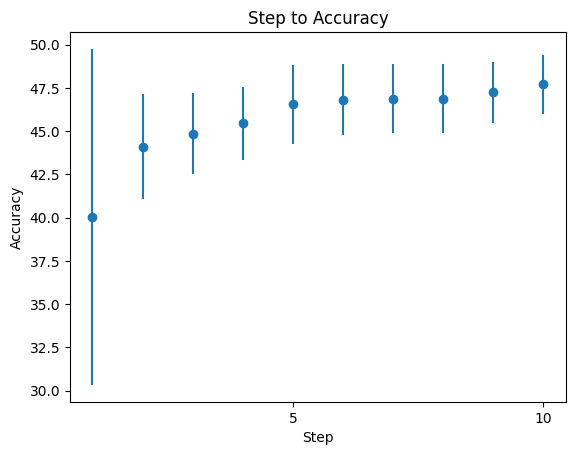

In [7]:
import statistics
import matplotlib.pyplot as plt

# load opro.json
with open(SAVE_PATH) as f:
    opro_results = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {
    step: (
        statistics.mean(opro_results[step].values()),
        statistics.stdev(opro_results[step].values()),
    )
    for step in opro_results
}

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(
    step_to_accuracy.keys(),
    [accuracy[0] for accuracy in step_to_accuracy.values()],
    yerr=[accuracy[1] for accuracy in step_to_accuracy.values()],
    fmt="o",
)
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")
ax.set_title("Step to Accuracy")

In [8]:
opro_results[str(len(opro_results))]

{'Summarize the text below: {TEXT}. \nMake sure your summary includes all the important points and is clear and informative, and well-organized.': 53.426304319986464,
 'Summarize the following text: {TEXT}. Ensure your summary is comprehensive, informative, and flows naturally. Make sure all the key points are included and presented in a coherent and engaging manner.': 49.914992937886325,
 'Please summarize the following text: {TEXT}. Think step by step.': 49.56293326150442,
 'Summarize the following text: {TEXT} Make sure the answer is natural and comprehensive.': 48.482160952774194,
 'Summarize the following text, keep it comprehensive, concise, and accurate, along with being natural and human-like: {TEXT}': 48.24513589253414,
 'Summarize the following text: {TEXT} To do this, make sure your summary includes all the important details, is clear and informative, well-organized, natural, comprehensive, and engaging.': 48.10797416692263,
 'Summarize the following text: {TEXT}. Be compreh

In [9]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"Initial Prompt: {score(CHOSEN_PROMPT, testing_sample)}")
print(f"Optimized Prompt ({best_instruction}): {score(best_instruction, testing_sample)}")

Please summarize the following text: {TEXT}:   0%|          | 0/25 [00:00<?, ?it/s]

Initial Prompt: 37.11102688819135


Summarize the text below: {TEXT}. 
Make sure your summary includes all the important points and is clear and i…

Optimized Prompt (Summarize the text below: {TEXT}. 
Make sure your summary includes all the important points and is clear and informative, and well-organized.): 37.2377206243922


In [10]:
original_dataset = Dataset.from_dict(summary_dataset[:150])
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"Initial Prompt: {score(CHOSEN_PROMPT, original_dataset)}")
print(f"Optimized Prompt ({best_instruction}): {score(best_instruction, original_dataset)}")

Please summarize the following text: {TEXT}:   0%|          | 0/150 [00:00<?, ?it/s]

Initial Prompt: 20.675759410887835


Summarize the text below: {TEXT}. 
Make sure your summary includes all the important points and is clear and i…

Optimized Prompt (Summarize the text below: {TEXT}. 
Make sure your summary includes all the important points and is clear and informative, and well-organized.): 22.854674456754207


### Example

In [11]:
res = opro.generate(
    best_instruction.format(TEXT=summary_dataset["text"][0]),
    model="gemma",  # gemma
)
summary_dataset["summary"][0], res, score_rouge(res, summary_dataset["summary"][0])

('Existing property tax law establishes a veterans’ organization exemption under which property is exempt from taxation if, among other things, that property is used exclusively for charitable purposes and is owned by a veterans’ organization.\nThis bill would provide that the veterans’ organization exemption shall not be denied to a property on the basis that the property is used for fraternal, lodge, or social club purposes, and would make specific findings and declarations in that regard. The bill would also provide that the exemption shall not apply to any portion of a property that consists of a bar where alcoholic beverages are served.\nSection 2229 of the Revenue and Taxation Code requires the Legislature to reimburse local agencies annually for certain property tax revenues lost as a result of any exemption or classification of property for purposes of ad valorem property taxation.\nThis bill would provide that, notwithstanding Section 2229 of the Revenue and Taxation Code, no 